## Imports

In [61]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.metrics import f1_score, classification_report

In [62]:
PREPROCESSED_DATA_PATH = "../../../data/preprocessed/"

## Read Data

In [63]:
train_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "train.parquet")

val_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "validation.parquet")
small_test_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "test.parquet")

test_df = pd.concat([val_df, small_test_df], axis=0)

## Split Data Into Training and Testing

In [64]:
TARGET = 'copiesSold'

X_train = train_df.drop(columns=TARGET)
y_train = train_df[TARGET]

X_test = test_df.drop(columns=TARGET)
y_test = test_df[TARGET]

In [65]:
pd.set_option('display.max_columns', None)
X_train.head()

,steam_achievements,steam_trading_cards,workshop_support,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,reviewScore,has_demo,demo_count,has_dlc,dlc_count,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest,publisherClass_Indie,publisherClass_Other
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11655,0,0,0,-0.127185,1,0.0,2024,0.230306,-0.973118,-0.959158,-0.331901,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.129008,-0.485228,-0.422150,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
9303,0,0,0,-0.127185,1,0.0,2024,-0.060213,-0.998186,-1.631332,1.072290,0,0,0,0,0.0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.430898,0.109341,0.140908,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
56618,0,0,0,-0.127185,1,0.0,2007,0.179767,-0.983709,-0.061180,-0.331901,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.575401,0.109341,0.301146,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,1.0,0.0
55579,1,0,0,0.105103,1,0.0,2019,-0.188227,0.982126,-1.631332,-0.331901,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-0.129008,0.703911,0.243282,-0.241008,7.064584,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,1.0,0.0
64439,1,0,0,-0.069113,1,0.0,2022,0.280231,-0.959933,-1.631332,1.180305,0,0,1,1,0.0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,-0.833418,-1.079798,-0.496087,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0


In [66]:
y_train.head()

index
11655    0
9303     0
56618    0
55579    1
64439    1
Name: copiesSold, dtype: int64

## Check Data Balance

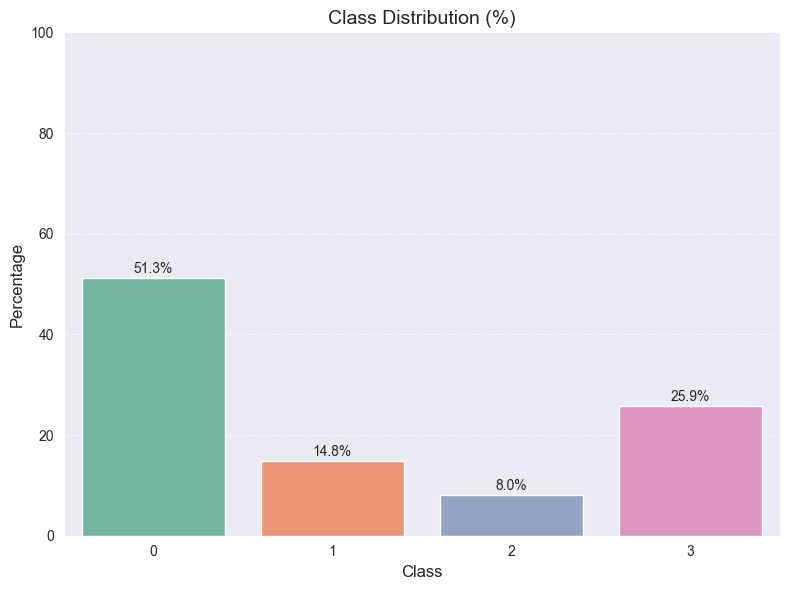

In [67]:
# Calculate class distribution percentages
class_percentages = y_train.value_counts(normalize=True).sort_index() * 100
df_plot = pd.DataFrame({
    'Class': class_percentages.index,
    'Percentage': class_percentages.values
})

plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_plot,
    x='Class',
    y='Percentage',
    hue='Class',
    palette='Set2',
    legend=False
)

plt.title('Class Distribution (%)', fontsize=14)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(df_plot['Percentage']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## Define Models and Hyperparameter Grids

In [68]:
models = {
    'LogisticRegression': {
        'class': LogisticRegression,
        'params': {
            'C': [0.01, 0.1, 1],
            'fixed': {
                'solver': 'liblinear',
                'max_iter': 1000,
                'class_weight': 'balanced',
                'penalty': 'l2',
                'random_state': 42
            }
        }
     },
    'LinearSVC': {
        'class': LinearSVC,
        'params': {
            'C': [0.1, 1.0, 10, 100],
            'fixed': {
                'max_iter': 10000,
                'dual' : False,
                'loss': 'squared_hinge',
                'class_weight': 'balanced',
                'penalty': 'l2',
                'random_state': 42
            }
        }
    },
    'XGBoost': {
        'class': XGBClassifier,
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'fixed': {
                'eval_metric': 'mlogloss',
                'n_jobs': -1,
                'random_state': 42,

            }
        }
    }
}

## Feature Selection and Hyperparameter Tuning

In [69]:
# Initialize results storage
best_params = {}
best_selectors = {}
best_models = {}
tuning_results = {model_name: {} for model_name in models.keys()}
# For imbalanced multi-class
scoring = make_scorer(f1_score, average = 'macro')

for model_name, config in models.items():
    print(f"\n=== Tuning {model_name} ===")

    model_class = config['class']
    fixed_params = config['params'].get('fixed', {})
    best_score = -np.inf

    for param_name, param_values in config['params'].items():
        if param_name == 'fixed':
            continue

        param_scores = []
        print(f"\nTuning {param_name}...")

        for value in param_values:
            print(f"  Testing {param_name}={value}")

            # 1. Create model with current parameters
            model = model_class(**{**fixed_params, param_name: value})

            # 2. Feature selection with F1 scoring
            selector = RFECV(
                estimator = model,
                cv = 3,
                scoring = scoring,
                n_jobs = -1,
                verbose = 1
            )
            X_selected = selector.fit_transform(X_train, y_train)
            print(f"    Selected {X_selected.shape[1]} features")

            # 3. Evaluate with class-weighted scoring
            score = cross_val_score(model,
                X_selected,
                y_train,
                cv = 3,
                scoring = scoring,
                n_jobs = -1,
                verbose = 1
            ).mean()
            print(f"    F1 Macro Score: {score:.4f}")

            param_scores.append(score)

            # 4. Track best performance
            if score > best_score:
                best_score = score
                best_params[model_name] = {**fixed_params, param_name: value}
                best_selector = selector
                print(f"    New best score: {score:.4f}")

        tuning_results[model_name][param_name] = {
            'values': param_values,
            'scores': param_scores
        }

    # Train final model
    final_model = model_class(**best_params[model_name])
    final_model.fit(best_selector.transform(X_train), y_train)
    best_models[model_name] = final_model
    best_selectors[model_name] = best_selector


=== Tuning LogisticRegression ===

Tuning C...
  Testing C=0.01
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
    Selected 39 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


    F1 Macro Score: 0.5252
    New best score: 0.5252
  Testing C=0.1
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
    Selected 36 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


    F1 Macro Score: 0.5298
    New best score: 0.5298
  Testing C=1
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
    Selected 46 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


    F1 Macro Score: 0.5299
    New best score: 0.5299

=== Tuning LinearSVC ===

Tuning C...
  Testing C=0.1
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
    Selected 44 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


    F1 Macro Score: 0.5230
    New best score: 0.5230
  Testing C=1.0
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
    Selected 44 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished


    F1 Macro Score: 0.5230
    New best score: 0.5230
  Testing C=10
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
    Selected 44 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished


    F1 Macro Score: 0.5230
    New best score: 0.5230
  Testing C=100
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
    Selected 45 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


    F1 Macro Score: 0.5231
    New best score: 0.5231

=== Tuning XGBoost ===

Tuning learning_rate...
  Testing learning_rate=0.01
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitt

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


    F1 Macro Score: 0.5738
    New best score: 0.5738
  Testing learning_rate=0.05
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
    Selected 41 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished


    F1 Macro Score: 0.5952
    New best score: 0.5952
  Testing learning_rate=0.1
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
    Selected 25 fe

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished


    F1 Macro Score: 0.6059
    New best score: 0.6059

Tuning max_depth...
  Testing max_depth=3
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
    Selected 28 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished


    F1 Macro Score: 0.5995
  Testing max_depth=5
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
    Selected 24

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


    F1 Macro Score: 0.6112
    New best score: 0.6112
  Testing max_depth=7
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
    Selected 26 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


    F1 Macro Score: 0.6086


## Visualizing Hyperparameter Tuning Results

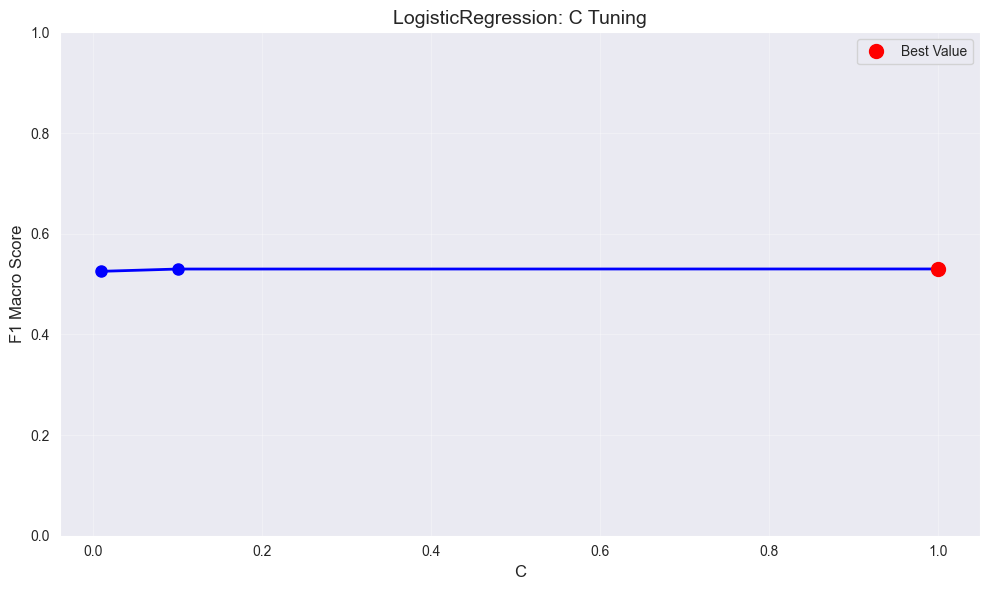

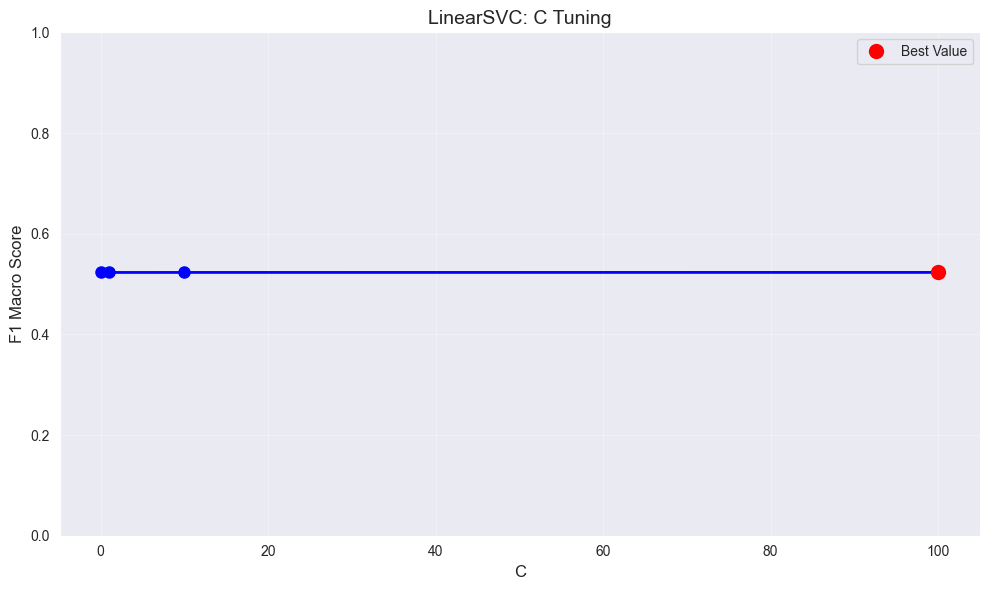

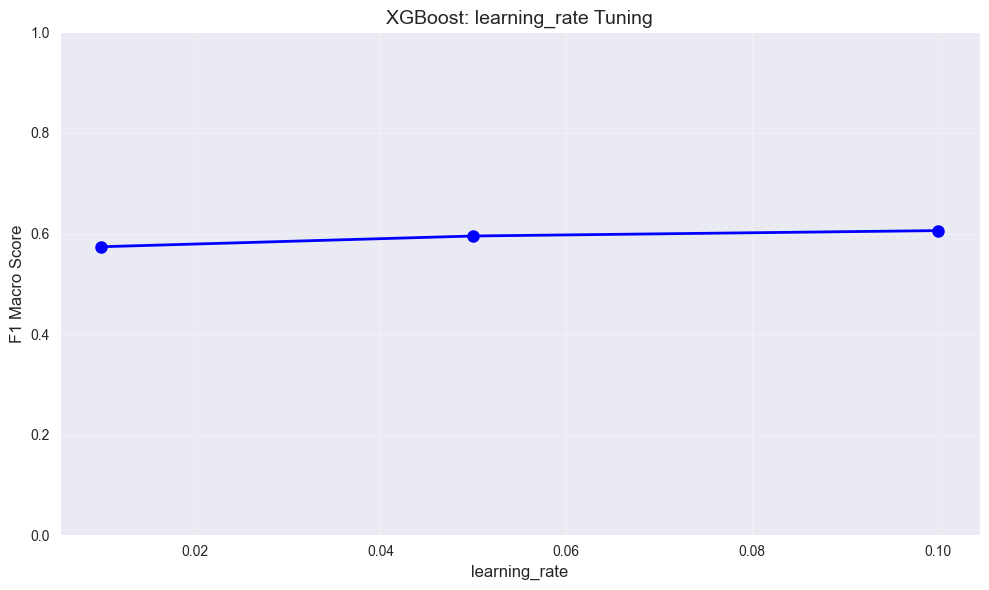

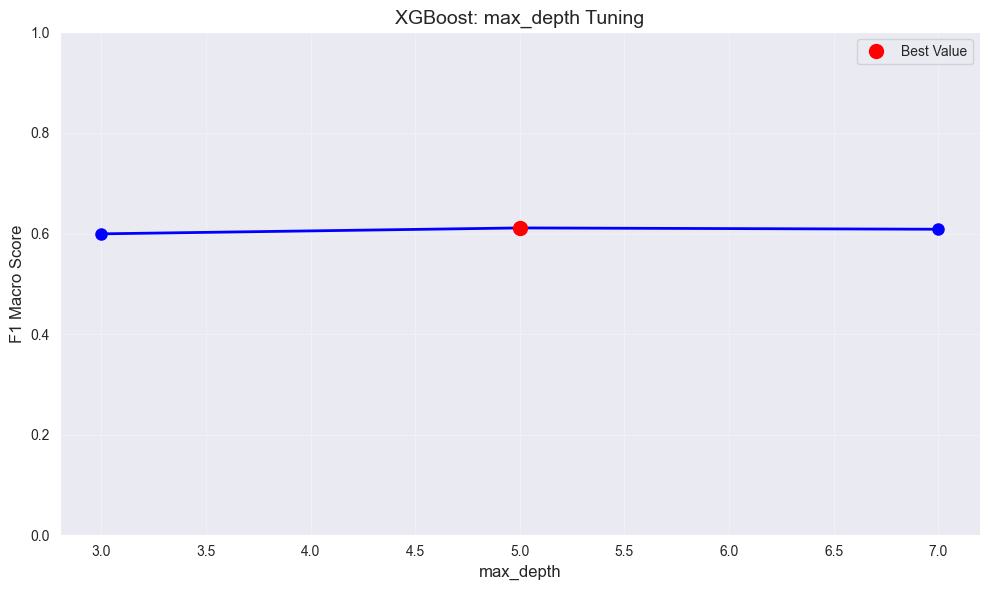

In [70]:
# --- Visualization ---
for model_name, param_data in tuning_results.items():
    for param_name, data in param_data.items():
        plt.figure(figsize=(10, 6))

         # Line plot for numeric parameters
        plt.plot(data['values'], data['scores'], 'bo-', markersize = 8, linewidth = 2)
        best_val = best_params[model_name].get(param_name)

        if best_val is not None and best_val in data['values']:
            best_idx = data['values'].index(best_val)
            plt.plot(best_val, data['scores'][best_idx], 'ro', markersize = 10, label = 'Best Value')
            plt.legend()

        plt.title(f'{model_name}: {param_name} Tuning', fontsize=14)
        plt.xlabel(param_name, fontsize=12)
        plt.ylabel('F1 Macro Score', fontsize=12)
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


## Training and Testing


=== Evaluating LogisticRegression ===
              precision    recall  f1-score   support

      Bronze       0.78      0.82      0.80      7080
      Silver       0.41      0.33      0.37      2032
        Gold       0.48      0.56      0.52      1138
    Platinum       0.46      0.43      0.45      3635

    accuracy                           0.63     13885
   macro avg       0.53      0.54      0.53     13885
weighted avg       0.62      0.63      0.62     13885


=== Evaluating LinearSVC ===
              precision    recall  f1-score   support

      Bronze       0.78      0.82      0.80      7080
      Silver       0.39      0.36      0.38      2032
        Gold       0.46      0.55      0.50      1138
    Platinum       0.46      0.40      0.43      3635

    accuracy                           0.62     13885
   macro avg       0.52      0.53      0.53     13885
weighted avg       0.61      0.62      0.62     13885


=== Evaluating XGBoost ===
              precision    recall

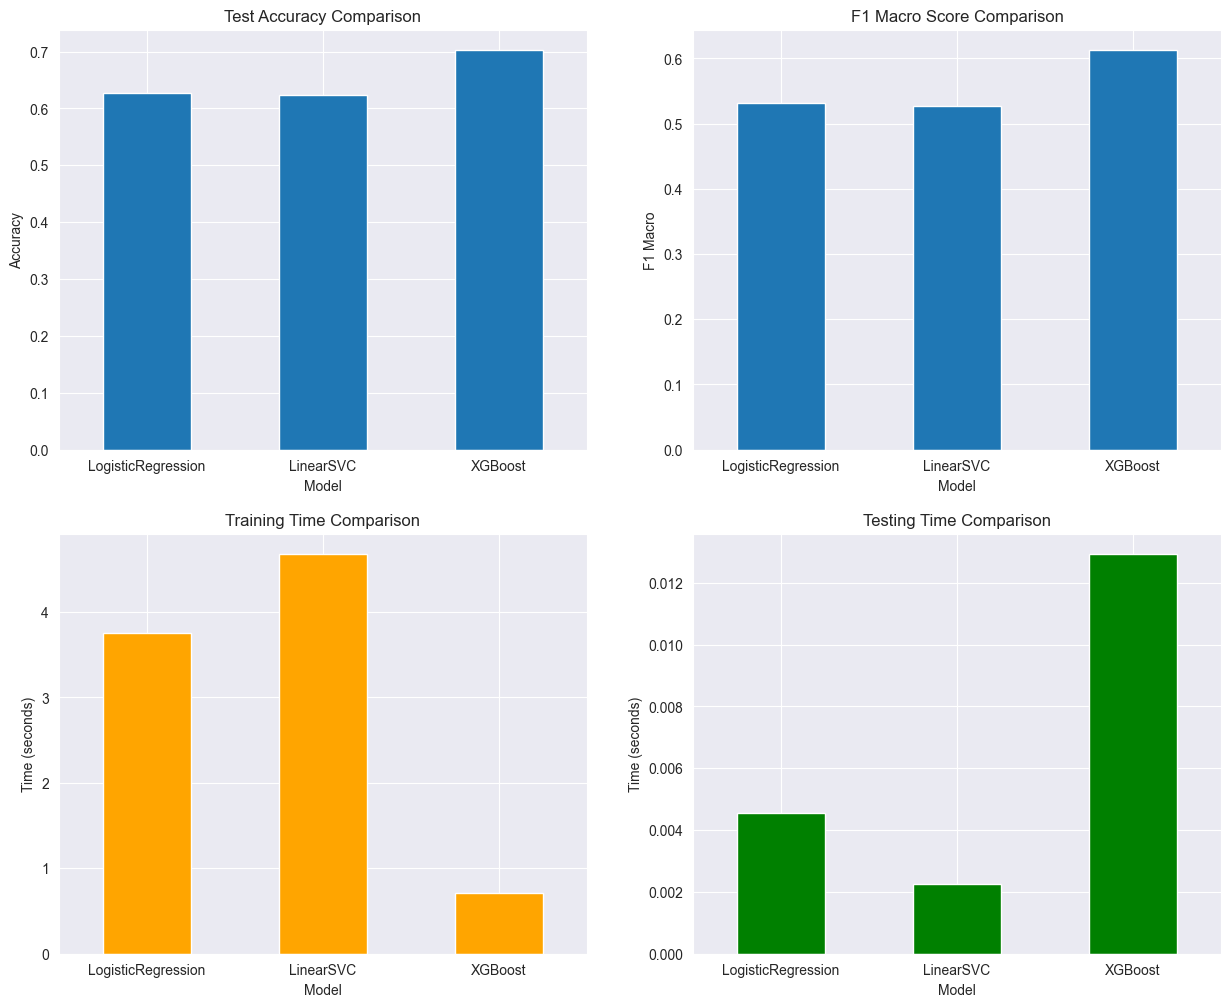

In [71]:
# Initialize metrics storage
metrics = {
    'Model': [],
    'Train Time': [],
    'Test Time': [],
    'Accuracy': [],
    'F1 Macro': [],
    'F1 Weighted': []
}

for model_name in models.keys():
    print(f"\n=== Evaluating {model_name} ===")

    # Retrieve model class and params
    model_class = models[model_name]['class']
    fixed_params = models[model_name]['params'].get('fixed', {})

    # Get selected features
    selector = best_selectors[model_name]
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)

    # Create and train model
    model = model_class(**{**fixed_params, **best_params[model_name]})

    # Training
    start = time.time()
    model.fit(X_train_sel, y_train)
    train_time = time.time() - start

    # Testing
    start = time.time()
    y_pred = model.predict(X_test_sel)
    test_time = time.time() - start

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    # Store metrics
    metrics['Model'].append(model_name)
    metrics['Train Time'].append(train_time)
    metrics['Test Time'].append(test_time)
    metrics['Accuracy'].append(accuracy)
    metrics['F1 Macro'].append(f1_macro)
    metrics['F1 Weighted'].append(f1_weighted)

    # Print classification report
    print(classification_report(
        y_test, y_pred, target_names=['Bronze', 'Silver', 'Gold', 'Platinum']
    ))

# Convert metrics to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics).set_index('Model')

# Plot all metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy plot
metrics_df['Accuracy'].plot(kind='bar', ax=axes[0,0], rot=0)
axes[0,0].set_title('Test Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')

# F1 Macro plot
metrics_df['F1 Macro'].plot(kind='bar', ax=axes[0,1], rot=0)
axes[0,1].set_title('F1 Macro Score Comparison')
axes[0,1].set_ylabel('F1 Macro')

# Training Time plot
metrics_df['Train Time'].plot(kind='bar', ax=axes[1,0], rot=0, color='orange')
axes[1,0].set_title('Training Time Comparison')
axes[1,0].set_ylabel('Time (seconds)')

# Testing Time plot
metrics_df['Test Time'].plot(kind='bar', ax=axes[1,1], rot=0, color='green')
axes[1,1].set_title('Testing Time Comparison')
axes[1,1].set_ylabel('Time (seconds)')

# plt.tight_layout()
plt.show()


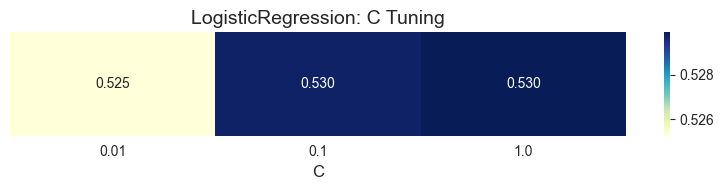

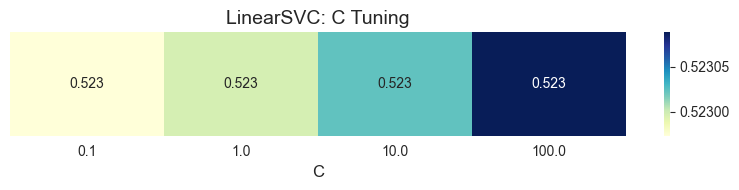

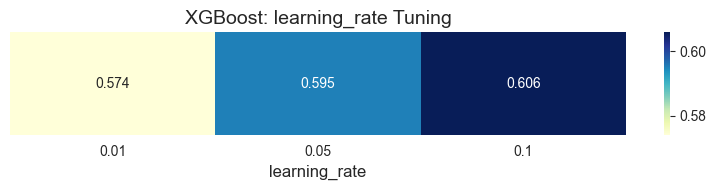

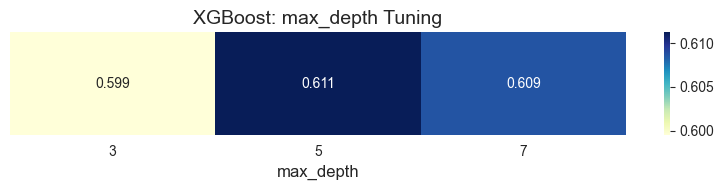

In [72]:
# # --- Heatmap Visualization ---
# for model_name, param_data in tuning_results.items():
#     for param_name, data in param_data.items():
#         # Convert to DataFrame
#         df_plot = pd.DataFrame({
#             param_name: data['values'],
#             'F1 Macro Score': data['scores']
#         })
#
#         # Convert parameter values to string (for consistent heatmap labels)
#         df_plot[param_name] = df_plot[param_name].astype(str)
#
#         # Pivot to form a 2D structure: one row, many columns
#         df_heat = df_plot.set_index(param_name).T
#
#         # Plot heatmap
#         plt.figure(figsize=(max(8, len(df_heat.columns) * 0.7), 2))
#         sns.heatmap(df_heat, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
#
#         plt.title(f'{model_name}: {param_name} Tuning', fontsize=14)
#         plt.xlabel(param_name, fontsize=12)
#         plt.yticks([])  # hide y-axis (since it's just "F1 Macro Score")
#         plt.tight_layout()
#         plt.show()
